In [19]:
import polars as pl
import os
import numpy as np
import warnings
import matplotlib.pyplot as plt
import logging
from math import fabs
from typing import List, Tuple, Dict
from datetime import datetime

warnings.filterwarnings("ignore")
commission = 1 / 1000.0
commission = 5 / 10000.0
commission = 10 / 10000.0
# commission = 0
START_CASH = 100000
import pandas as pd

print(f"Polars version: {pl.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

USE_HOUR_DATA = 0
DEBUG = 1
EPS = 1e-6

Polars version: 1.5.0
Pandas version: 2.0.3
NumPy version: 1.24.4


In [20]:
from crypto_utils import GetDateTimeAsFileName
LOG_NAME = f'log/factor_backtest_eval_{GetDateTimeAsFileName()}.log'
print (f'log file: {LOG_NAME}')


logger = logging.getLogger()
for handler in logger.handlers[:]:
    logger.removeHandler(handler)


# Configure logging
LOG_LEVEL = logging.DEBUG

logging.basicConfig(filename=LOG_NAME, level = LOG_LEVEL,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Set the log level to DEBUG
logger.setLevel(LOG_LEVEL)

print(f"Logging configured. Log file: {LOG_NAME}")


log file: log/factor_backtest_eval_1217_1810.log
Logging configured. Log file: log/factor_backtest_eval_1217_1810.log


In [21]:
TRADE_RANK_NUM = 20
pl.Config.set_tbl_rows(TRADE_RANK_NUM)
logger.info(f"TRADE_RANK_NUM: {TRADE_RANK_NUM}")

ROLLING_DAY = 600
LINEAR_INPUT_FILE = f'data/linear_compound_factor_rolling_{ROLLING_DAY}_input(all_data_1d_boris_converted_with_amihud_alpha101).parquet'
LINEAR_INPUT_FILE = f"data/linear_compound_factor_rolling_{ROLLING_DAY}.parquet"
LINEAR_INPUT_FILE = f"data/linear_compound_factor_rolling_{ROLLING_DAY}_input(day_alpha101_sep29).parquet"

# data/linear_compound_factor_input_all_data_1d_boris_converted_with_amihud_alpha101.parquet
LINEAR_INPUT_FILE = f'data/linear_compound_factor_rolling_{ROLLING_DAY}_input_all_data_1d_boris_converted_with_amihud_alpha101.parquet'
LINEAR_INPUT_FILE = f'data/linear_compound_factor_input_all_data_1d_boris_converted_with_amihud_alpha101.parquet'

LINEAR_INPUT_FILE = f'production/all_data_1d_boris_converted_compound_prod.parquet'
LINEAR_INPUT_FILE = f'production/compound_factor.parquet'
LINEAR_INPUT_FILE = f'production/predictions.parquet'
LINEAR_INPUT_FILE = f'production/predictions_20241128.parquet'
LINEAR_INPUT_FILE = f'production/z790_predictions.parquet'
LINEAR_INPUT_FILE = f'data/improve_predictions_20241201.parquet'
LINEAR_INPUT_FILE = f'data/predictions_20241129.parquet'
LINEAR_INPUT_FILE = f'production/old_pred.parquet'
LINEAR_INPUT_FILE = f'production/z790_pred.parquet'

LINEAR_INPUT_FILE = f'production/pred_20230101.parquet'
LINEAR_INPUT_FILE = f'production/pred_20240625.parquet'
LINEAR_INPUT_FILE = f'production/pred_20230101_recent360.parquet'
LINEAR_INPUT_FILE = f'production/pred_20240625_recent720.parquet'
LINEAR_INPUT_FILE = f'production/pred_20230101_recent720.parquet'

LINEAR_INPUT_FILE = f'production/new_pred.parquet'
LINEAR_INPUT_FILE = f'../production/data/v2_pred.parquet'
# LINEAR_INPUT_FILE = f'production/temp.parquet'

# LINEAR_INPUT_FILE = f'gubo/data/alpha1_predictions.parquet'

if os.path.exists(LINEAR_INPUT_FILE):
    print (f'LINEAR_INPUT_FILE {LINEAR_INPUT_FILE }')
else:
    logger.error(f'LINEAR_INPUT_FILE {LINEAR_INPUT_FILE } does not exist')
    print(f'LINEAR_INPUT_FILE {LINEAR_INPUT_FILE } does not exist')
    exit(1)

logger.info(f'LINEAR_INPUT_FILE {LINEAR_INPUT_FILE }')

LINEAR_INPUT_FILE ../production/data/v2_pred.parquet


In [22]:

ENABLE_EARLY_CUT_LOSS = 0
CUT_LOSS_PCT_THRESHOLD = 10  # cut loss, 30 is good to get 2.3 sharp
logger.info (f'ENABLE_EARLY_CUT_LOSS: {ENABLE_EARLY_CUT_LOSS}, CUT_LOSS_PCT_THRESHOLD: {CUT_LOSS_PCT_THRESHOLD}')

USE_FACTOR_POS_RATIO = 0
logger.info (f'USE_FACTOR_POS_RATIO: {USE_FACTOR_POS_RATIO}')

LONG_TRADE_RANK_RATIO = 1.0
SHORT_TRADE_RANK_RATIO = 0.5
logger.info (f'LONG_TRADE_RANK_RATIO: {LONG_TRADE_RANK_RATIO}, SHORT_TRADE_RANK_RATIO: {SHORT_TRADE_RANK_RATIO}')

DYNAMIC_POS_SCALE = 0
# 未来n天的平均收益率阈值，用来判断是否需要让多空仓位不平衡
POS_RET_THRESHOLD = 3.0
logger.info (f'DYNAMIC_POS_SCALE: {DYNAMIC_POS_SCALE} === threshold: {POS_RET_THRESHOLD}')


VOL_FILTER_RATIO = 30
# VOL_FILTER_RATIO = 0

VOL_COL_FILTER_NAME = 'volume'  # volume in coin,  quote_volume, in USDT
logger.info (f'VOL_FILTER_RATIO: {VOL_FILTER_RATIO}')
logger.info (f'VOL_COL_FILTER_NAME: {VOL_COL_FILTER_NAME}')

In [23]:
def read_delist_info(file_path="delist/delist_info.csv"):
    """
    Read CSV and convert string dates to datetime.
    Expects dates in format: YYYY,MM,DD,HH,00
    """
    df = pl.read_csv(file_path).with_columns([
        pl.col("announce_time").str.strptime(
            pl.Datetime("ms", "UTC"),
            "%Y,%m,%d,%H,%M"
        ),
        pl.col("end_trade_time").str.strptime(
            pl.Datetime("ms", "UTC"),
            "%Y,%m,%d,%H,%M"
        )
    ])
    return df

delist_info = read_delist_info()
delist_info

symbol,announce_time,end_trade_time
str,"datetime[ms, UTC]","datetime[ms, UTC]"
"""AGIXUSDT""",2023-07-11 19:00:00 UTC,2023-07-20 09:00:00 UTC
"""ANTUSDT""",2024-03-25 13:00:00 UTC,2024-04-01 09:00:00 UTC
"""DGBUSDT""",2024-03-25 13:00:00 UTC,2024-04-01 09:00:00 UTC
"""CTKUSDT""",2024-03-25 13:00:00 UTC,2024-04-01 09:00:00 UTC
"""AUDIOUSDT""",2024-05-08 13:00:00 UTC,2024-05-16 09:00:00 UTC
"""IDEXUSDT""",2024-05-08 13:00:00 UTC,2024-05-16 09:00:00 UTC
"""SLPUSDT""",2024-05-08 13:00:00 UTC,2024-05-16 09:00:00 UTC
"""GLMRUSDT""",2024-05-08 13:00:00 UTC,2024-05-16 09:00:00 UTC
"""MDTUSDT""",2024-05-08 13:00:00 UTC,2024-05-16 09:00:00 UTC


In [24]:
def CompareLongShortList (long_df: pl.DataFrame, short_df: pl.DataFrame):
    for df in [long_df, short_df]:
        stats = df.select(
            pl.col("change_pct").mean().alias("mean"),
            pl.col("change_pct").median().alias("median"),
            pl.col("change_pct").min().alias("min"),
            pl.col("change_pct").max().alias("max"),
            pl.col("change_pct").std().alias("std_dev"),
            pl.col("change_pct").quantile(0.25).alias("q1"),
            pl.col("change_pct").quantile(0.75).alias("q3")
        )
        logger.debug (f'=== stats: {stats}')
        # if df == long_df:
        #     logger.debug (f'long stats: {stats}')
        # else:
        #     logger.debug (f'short stats: {stats}')
        
    # compare two part
    long_total_change = long_df["change_pct"].sum()
    short_total_change = short_df["change_pct"].sum()

    logger.debug("Overall Performance Comparison:")
    logger.debug(f"    Long Total Change: {long_total_change:.2f}%")
    logger.debug(f"    Short Total Change: {short_total_change:.2f}%")
    logger.debug(f"    Difference (Long - Short): {long_total_change - short_total_change:.2f}%")

In [25]:

def AnalysePnLTrace(pnl, annual_risk_free_rate=0.03, trading_days_per_year=365):
    """
    Analyze the PnL trace to compute various financial metrics.

    Parameters:
        pnl (list or numpy.array): A series of net asset values or account balances over time.
        annual_risk_free_rate (float): The annual risk-free rate, default is 3% (0.03).
        trading_days_per_year (int): The number of trading days per year, default is 252.

    Returns:
        dict: A dictionary with keys as metric names and values as metric values.
    """
    if not isinstance(pnl, np.ndarray):
        pnl = np.array(pnl)

    # Calculate final return
    final_return = (pnl[-1] / pnl[0] - 1) * 100  # in percentage

    # Calculate daily returns
    daily_returns = pnl[1:] / pnl[:-1] - 1

    # Calculate Sharpe Ratio
    daily_risk_free_rate = (1 + annual_risk_free_rate)**(1 / trading_days_per_year) - 1
    excess_returns = daily_returns - daily_risk_free_rate
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(trading_days_per_year)

    # Calculate Maximum Drawdown
    cumulative_returns = np.cumprod(1 + daily_returns)  # cumulative product of returns
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = np.min(drawdown)  # most negative value

    # Calculate Volatility (annualized standard deviation of daily returns)
    volatility = np.std(daily_returns) * np.sqrt(trading_days_per_year)

    # Calculate Average Daily Return
    average_daily_return = np.mean(daily_returns)

    # Compile all metrics into a dictionary
    metrics = {
        'sharpe_ratio': sharpe_ratio,
        'final_return_pct(%)': final_return,
        'max_drawdown(%)': max_drawdown * 100.0,
        'volatility': volatility,
        'average_daily_return': average_daily_return
    }

    return metrics

In [26]:
def factor_stats(n = 365, pnl:pl.Series = None):
    # TODO:输入的pnl是当天的收益率，没有做累加，要把输入进行调整
    # # Calculate the daily returns (difference)
    # pnl_returns = pl.Series([0] + [(pnl[i] - pnl[i-1]) / pnl[i-1] for i in range(1, len(pnl))])
    # # Replace the original pnl with the calculated returns
    # pnl = pnl_returns
    # Convert numpy array to polars Series
    
    # Calculate daily returns
    daily_returns = pl.Series([0] + [(pnl[i] - pnl[i-1]) / pnl[i-1] for i in range(1, len(pnl))])
    
    # Replace the original pnl with the calculated returns
    pnl = daily_returns
    # print (f'after ==pnl: {pnl}')
    # print (f'input pnl: {pnl}')
    net_value = pnl.cum_sum() + 1.0
    sharpe = n ** 0.5 * pnl.mean() / pnl.std()
    ann_return = n * pnl.mean()
    maxdd = (-(net_value / net_value.cum_max() - 1)).max()
    # print (f'net_value {net_value / net_value.cum_max()} === maxdd {maxdd}')
    calmar_ratio = ann_return / maxdd

    print("ann_return =", round(ann_return, 4), end='  ')
    print("sharpe =", round(sharpe, 4), end='  ')
    print("maxdd =", round(maxdd, 4), end='  ')
    print("calmar_ratio =", round(calmar_ratio, 4), end='  ')
    return ann_return, sharpe, maxdd, calmar_ratio


In [27]:
def GetTradeableSymbolList(current_factors, open_pos_time) -> list:
    # 找出所有因子值不是NaN的symbol
    non_nan_cols_factors = [
        col
        for col in current_factors.columns
        if (
            current_factors[col].null_count() == 0
            and current_factors[col].is_nan().sum() == 0
        )
    ]

    # check delist
    delisted_symbol: set = set(
        delist_info.filter(
            pl.col("announce_time")
            <= pl.lit(open_pos_time).cast(pl.Datetime("ms", "UTC"))
        )["symbol"].to_list()
    )

    non_nan_cols_factors = [x for x in non_nan_cols_factors if x not in delisted_symbol]

    return non_nan_cols_factors, delist_info.filter(
            pl.col("announce_time")
            <= pl.lit(open_pos_time).cast(pl.Datetime("ms", "UTC"))
        )

    current_ret = input_ret.filter(
        pl.col("open_time") == current_open_time_when_open_pos
    ).drop("open_time")
    non_nan_cols_ret = [
        col
        for col in current_ret.columns
        if current_ret[col].null_count() == 0
        and current_ret[col].is_nan().sum() == 0
        and current_ret[col].count() > 0
    ]

    logger.debug(
        f"close_pos_time {current_open_time_when_open_pos} === non_nan_cols_factors: {non_nan_cols_factors} === non_nan_cols_ret: {non_nan_cols_ret}"
    )

    # 取交集得到两者都非NaN的列
    ret_tradeable_symbol_list = list(set(non_nan_cols_factors) & set(non_nan_cols_ret))
    return ret_tradeable_symbol_list


def GetNonZeroSortedTuple(df: pl.DataFrame):
    col_arr: list = df.columns
    val = df.to_numpy()[0]
    assert len(col_arr) == len(val), f"len col: {len(col_arr)} != len val: {len(val)}"
    ret_list = []
    for i, j in zip(col_arr, val):
        if j != 0:
            ret_list.append((i, j))
    ret_list = sorted(ret_list)
    return ret_list

In [28]:
from typing import List, Tuple
from scipy.optimize import minimize


def optimize_portfolio(
    expected_returns: np.ndarray,
    cov_matrix: np.ndarray,
    risk_free_rate: float = 0.02,
    max_leverage: float = 4.0,
) -> np.ndarray:
    """
    Optimize a portfolio using the Sharpe ratio as the objective.

    :param expected_returns: Array of expected returns for each asset
    :param cov_matrix: Covariance matrix of asset returns
    :param risk_free_rate: Risk-free rate, default is 0.02 (2%)
    :param max_leverage: Maximum allowed leverage, default is 1.0 (100%)
    :return: Array of optimal weights for each asset
    """
    n_assets = len(expected_returns)

    def objective(weights: np.ndarray) -> float:
        portfolio_return = np.sum(expected_returns * weights)
        return -portfolio_return  # We minimize the negative Sharpe ratio

        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        return -sharpe_ratio  # We minimize the negative Sharpe ratio

    constraints: List[dict] = [
        {"type": "eq", "fun": lambda x: np.sum(x)},  # Weights sum to 0
        {
            "type": "ineq",
            "fun": lambda x: max_leverage - np.sum(np.abs(x)),
        },  # Leverage constraint
    ]

    bounds: List[Tuple[float, float]] = [
        (-1, 1) for _ in range(n_assets)
    ]  # Allow short selling

    initial_guess = n_assets * [0]
    methods = ["SLSQP", "trust-constr"]
    results = {}
    for method in methods:
        result = minimize(
            objective,
            initial_guess,
            method=method,
            bounds=bounds,
            constraints=constraints,
            options={"maxiter": 10000},
        )

        results[method] = {
            "success": result.success,
            "optimal_weights": result.x,
            "sharpe_ratio": -result.fun,
            "n_iterations": result.nit if "nit" in result else None,
            "message": result.message,
        }
        # print (f'method: {method} result: {results[method]}')

    for method in methods:
        if results[method]["success"]:
            return results[method]["optimal_weights"]
    assert 0, f"No method success: {results}"

In [29]:


def CalcEachPositionRatio(
    result_hour: pl.DataFrame,
    tradeable_symbol_list: List[str],
    long_symbol_list: List[str],
    short_symbol_list: List[str],
    cur_close_time: datetime,
    next_bar_open_time: datetime,
    current_factors: pl.DataFrame,
    return_pl: pl.DataFrame,
) -> Tuple[Dict[str, float], Dict[str, float]]:

    cur_close_return = return_pl.filter(pl.col("close_time") == cur_close_time).select(
        pl.col(tradeable_symbol_list)
    )
    cur_close_return_np = cur_close_return.to_numpy()[0]
    current_factors = current_factors.select(pl.col(tradeable_symbol_list))
    cur_factors_np = current_factors.to_numpy()[0]

    print(f"cur close return: {cur_close_return_np}")
    print(f"current_factors: {current_factors}")
    print(len(tradeable_symbol_list), len(cur_close_return_np), current_factors.shape, len(cur_factors_np))

    # step 1
    input_cov_matrix = (
        return_pl.filter(pl.col("close_time") <= cur_close_time)
        .drop("close_time")
        .select(pl.col(tradeable_symbol_list))
    )
    cov_matrix_np = input_cov_matrix.to_pandas().cov().to_numpy()

    optimal_weight = optimize_portfolio(cur_factors_np, cov_matrix_np)
    weight_dict = dict (zip (tradeable_symbol_list, optimal_weight))

    long_symbol_pos_ratio = [weight_dict[symbol] for symbol in long_symbol_list]
    short_symbol_pos_ratio = [weight_dict[symbol] for symbol in short_symbol_list]


    # The rest of the function implementation would go here
    # For now, we'll return placeholder dictionaries
    long_symbol_pos_ratio_dict = dict (zip (long_symbol_list, long_symbol_pos_ratio))
    short_symbol_pos_ratio_dict = dict (zip (short_symbol_list, short_symbol_pos_ratio))

    logger.debug (f'weight dict for all: {weight_dict}')
    logger.debug (f'long symbol pos ratio: {long_symbol_pos_ratio_dict}')
    logger.debug (f'short symbol pos ratio: {short_symbol_pos_ratio_dict}')

    return long_symbol_pos_ratio_dict, short_symbol_pos_ratio_dict

In [30]:
def GetSinglePnL(
    result_hour,
    compound_column_name,
    group_num=20,
    long_factor_combination_list=[1, 2, 3],
    update_position_time=1,
    leverage=1,
    trade_with_rank=0,
):
    logger.info(f"start get SinglePnl: {result_hour}")
    FACTOR_NAME = compound_column_name + f"_{update_position_time}day"
    FUT_N_DAY_RET_COL_NAME = f"open_price_fut_{update_position_time}day_ret"
    future_n_day_open_ret = (
        result_hour[["open_time", "symbol", FUT_N_DAY_RET_COL_NAME]]
        # all_time_hist_data[["open_time", "symbol", FUT_N_DAY_RET_COL_NAME]]
        .pivot(index="open_time", columns="symbol", values=FUT_N_DAY_RET_COL_NAME).sort(
            "open_time"
        )
    )

    result_hour = result_hour.with_columns (
        pl.lit (0).alias ( f"long_value_scale_{update_position_time}day")
    )

    long_scale = (
        result_hour[
            ["close_time", "symbol", f"long_value_scale_{update_position_time}day"]
        ]
        .pivot(
            index="close_time",
            columns="symbol",
            values=f"long_value_scale_{update_position_time}day",
        )
        .sort("close_time")
    )

    # 因为此时的因子值是在close_time的时候计算的，所以要用close_time
    factors = (
        result_hour[["close_time", "symbol", FACTOR_NAME]]
        .pivot(index="close_time", columns="symbol", values=FACTOR_NAME)
        .sort("close_time")
    )

    # 每根k线的开盘价
    open_df = (
        result_hour[["open_time", "symbol", "open"]]
        .pivot(index="open_time", columns="symbol", values="open")
        .sort("open_time")
    )

    # all_time_close_return = (
    #     all_time_hist_data[["close_time", "symbol", "close_return"]]
    #     .pivot(index="close_time", columns="symbol", values="close_return")
    #     .sort("close_time")
    # )

    # relalized volatility for OPEN price
    volatility_open_price = (
        result_hour[["open_time", "symbol", "open_price_volatility"]]
        .pivot(index="open_time", columns="symbol", values="open_price_volatility")
        .sort("open_time")
    )

    bar_close_vol = (
        result_hour[["close_time", "symbol", VOL_COL_FILTER_NAME]]
        .pivot(index="close_time", columns="symbol", values = VOL_COL_FILTER_NAME)
        .sort("close_time")
    )

    # relalized volatility for CLOSE price
    # volatility_close_price = (
    #     result_hour[["close_time", "symbol", "close_price_volatility"]]
    #     .pivot(index="close_time", columns="symbol", values="close_price_volatility")
    #     .sort("close_time")
    # )

    columns = future_n_day_open_ret.columns[1:]  # means all symbols
    all_symbols = columns

    # 在每一根k线走完的时候计算因子值，然后调仓
    # 所以要遍历每一个close_time，进行调仓
    factors.sort("close_time")
    time_array = factors["close_time"].to_numpy()

    time_array = time_array[:-1]  # the last line doesn't have next day return

    today_pnl = 1
    pnl = []
    cash = START_CASH
    latest_pnl = cash # 起始的pnl就等于现金总价值，此时没有任何持仓
    cur_position = pl.DataFrame(
        {col: [value] for col, value in zip(columns, [0] * len(columns))}
    )
    next_step_position = pl.DataFrame(
        {col: [value] for col, value in zip(columns, [0] * len(columns))}
    )

    # 用日线数据的时候，每一行是一天；小时数据的时候，每24行是一天
    update_row_index = (
        update_position_time if USE_HOUR_DATA == 0 else update_position_time * 24
    )
    fut_avg_long_pos_ret, fut_avg_short_pos_ret = 0, 0

    # used to count the PnL for current pos & stop loss early
    cur_pos_open_price: pl.DataFrame = None
    cur_hold_long_symbol_list = []
    cur_hold_short_symbol_list = []
    bar_open_time_to_close_pos = time_array[0] # only for init, no meaning

    for i, cur_close_time in enumerate(time_array):

        # 用下一根k线的开盘价作为调仓价格，open_time是1ms后
        time_delta: np.timedelta64 = np.timedelta64(1, "ms")

        next_bar_open_time = cur_close_time + time_delta
        all_open_price_when_open_pos = open_df.filter(
            pl.col("open_time") == next_bar_open_time
        ).drop("open_time")

        # check early cut loss
        if ENABLE_EARLY_CUT_LOSS and cur_pos_open_price is not None:
            each_symbol_change_pct = (
                all_open_price_when_open_pos / cur_pos_open_price - 1
            ) * 100.0
            for symbol in cur_hold_long_symbol_list + cur_hold_short_symbol_list:
                this_symbol_change_pct = each_symbol_change_pct[symbol].to_numpy()[0]
                this_symbol_hold_amount = cur_position[symbol].to_numpy()[0]

                if (
                    this_symbol_hold_amount > EPS
                    and this_symbol_change_pct < -CUT_LOSS_PCT_THRESHOLD
                ):
                    logger.debug(
                        f"cut loss for long: {symbol} == {this_symbol_change_pct}"
                    )
                elif (
                    this_symbol_hold_amount < -EPS
                    and this_symbol_change_pct > CUT_LOSS_PCT_THRESHOLD
                ):
                    logger.debug(
                        f"cut loss for short: {symbol} == {this_symbol_change_pct}"
                    )
                else:
                    continue

                logger.debug(
                    f"before close pos: {symbol} == cash {cash} == pos value {sum_row (all_open_price_when_open_pos * cur_position)}"
                )
                # close this position
                this_symbol_close_pos_price = all_open_price_when_open_pos[
                    symbol
                ].to_numpy()[0]
                cash += this_symbol_close_pos_price * this_symbol_hold_amount

                # commission
                this_symbol_trading_value = (
                    fabs(this_symbol_hold_amount) * this_symbol_close_pos_price
                )
                cash -= this_symbol_trading_value * commission

                logger.debug(
                    f"this_symbol_close_pos_price: {this_symbol_close_pos_price} == this_symbol_hold_amount: {this_symbol_hold_amount} === total value: {this_symbol_trading_value}"
                )

                logger.debug(f"before remove {symbol} == {cur_position}")
                cur_position = cur_position.with_columns(
                    pl.lit(0).alias(symbol)
                )  # set to 0 pos amount
                logger.debug(f"after remove {symbol} ==i========= {cur_position}")
                logger.debug(
                    f"cash after close pos: {cash}, total value: {sum_row (all_open_price_when_open_pos * cur_position)}"
                )

        # check if we are holding symbols which already delisted
        delisted_symbol: list = delist_info.filter(
            (pl.col("announce_time")
            >= pl.lit(cur_close_time).cast(pl.Datetime("ms", "UTC"))) & 
            (pl.col("end_trade_time") <= pl.lit(bar_open_time_to_close_pos).cast(pl.Datetime("ms", "UTC")))
            # 已经宣布了delist，并且结束交易的时间，在我们的预定平仓时间之前
        )["symbol"].to_list()

        for each_delist_symbol in delisted_symbol:
            if (
                each_delist_symbol in cur_position.columns
                and cur_position[each_delist_symbol].to_numpy()[0] != 0
            ):
                # 获取当前持仓数量
                current_position: float = float(
                    cur_position[each_delist_symbol].to_numpy()[0]
                )

                # 将持仓设置为0 - Polars方式
                cur_position = cur_position.with_columns(
                    pl.lit(0.0).alias(each_delist_symbol)
                )

                # 用下一天的开盘价来平仓
                next_bar_open_price = all_open_price_when_open_pos[
                    each_delist_symbol
                ].to_numpy()[0]
                cash += next_bar_open_price * current_position

                logger.warning(
                    f"cur_close_time {cur_close_time} == close the position with this delist symbol: {each_delist_symbol} == original_pos: {current_position}, set to 0 == next day open price {next_bar_open_price}"
                )
                logger.debug (delist_info.filter(pl.col("end_trade_time") <= pl.lit(bar_open_time_to_close_pos).cast(pl.Datetime("ms", "UTC"))))

        if i % update_row_index == 0:
            # for debug and check pnl
            # 计算 {update_position_time} 天后的平仓时间(也是在开盘价平仓，所以是open_time)
            # 每次调仓才会更新这个数值，表示什么时候关闭当前的仓位
            bar_open_time_to_close_pos = next_bar_open_time + np.timedelta64(
                update_position_time, "D"
            )

            logger.debug(
                f"cur time: {cur_close_time} == next bar open time: {next_bar_open_time} == close pos time: {bar_open_time_to_close_pos}"
            )

            # Before update the position, calc the total cash+position value

            # 选取当前时间点的数据
            current_factors = factors.filter(
                pl.col("close_time") == cur_close_time
            ).drop("close_time")

            tradeable_symbol_list, temp = GetTradeableSymbolList(
                current_factors,
                next_bar_open_time,
            )

            # try to avoid trade the last xx% volume symbol ============
            if VOL_FILTER_RATIO > 0:
                cur_bar_close_vol = bar_close_vol.filter(
                    pl.col("close_time") == cur_close_time
                )

                vol_for_all_symbols = []
                for symbol in tradeable_symbol_list:
                    vol_for_all_symbols.append(
                        cur_bar_close_vol[symbol].to_list()[0]
                    )
                vol_threshold = np.percentile(vol_for_all_symbols, VOL_FILTER_RATIO)
                logger.debug (f'close time {cur_close_time} == vol_threshold: {vol_threshold}')

                tradeable_symbol_list_with_large_vol = []
                for symbol in tradeable_symbol_list:
                    assert len ( cur_bar_close_vol[symbol].to_list()) > 0, f'{ cur_bar_close_vol[symbol].to_list()} == {symbol}'
                    if cur_bar_close_vol[symbol].to_list()[0] > vol_threshold:
                        tradeable_symbol_list_with_large_vol.append(symbol)
                logger.debug (f'{cur_close_time} == all trade symbol {len (tradeable_symbol_list)} == remain {len (tradeable_symbol_list_with_large_vol)} after VOL filter')

                tradeable_symbol_list = tradeable_symbol_list_with_large_vol
            # -------------------------

            logger.debug (f'tradeable list {tradeable_symbol_list} == next bar open time: {next_bar_open_time}')
            logger.debug (temp)

            if trade_with_rank == 0 and len(tradeable_symbol_list) < group_num:
                # 如果可以交易的symbol数目小于组数，那么无法进行交易
                pnl.append(today_pnl)
                continue

            # 把所有可以交易的symbol的因子值找出来
            long_factors = current_factors.select(tradeable_symbol_list).melt(
                id_vars=[],
                value_vars=tradeable_symbol_list,
                variable_name="symbol",
                value_name="factor_value",
            )

            if len(tradeable_symbol_list) == 0:
                pnl.append(pnl[-1])
                logger.warning(f"no tradeable symbol at {cur_close_time}")
                continue

            assert (
                long_factors["factor_value"].is_null().sum() == 0
            ), "factor_value column contains null values"
            assert (
                long_factors["factor_value"].is_nan().sum() == 0
            ), "factor_value column contains NaN values"

            # 对全部symbol按照因子值排序
            sorted_long_factors = long_factors.sort("factor_value")

            # 对全部symbol进行分组，计算每个组的symbol数目
            group_size = max(
                int(sorted_long_factors.height / group_num), 1
            )  # 避免除以零

            if trade_with_rank != 0:
                # 基于排序的名次交易（只做多前xx个），而不是基于分组交易
                rank_labels = (pl.arange(0, sorted_long_factors.height)).cast(pl.UInt32)
                sorted_long_factors = sorted_long_factors.with_columns(
                    rank_labels.alias("rank")
                )

                # Create Reverse Rank label
                max_rank = sorted_long_factors.height - 1
                reverse_rank_labels = (max_rank - rank_labels).cast(pl.UInt32)
                sorted_long_factors = sorted_long_factors.with_columns(
                    reverse_rank_labels.alias("reverse_rank")
                )
            else:
                # 创建组标签
                # 使用 pl.arange 生成行索引，然后除以每组大小，并取整获得组号
                group_labels = (
                    pl.arange(0, sorted_long_factors.height) / group_size
                ).cast(pl.UInt32)

                # 将组标签列添加到 DataFrame
                sorted_long_factors = sorted_long_factors.with_columns(
                    group_labels.alias("group")
                )

            logger.debug(f"sorted_long_factors: {sorted_long_factors}")

            # temp for verify the production
            symbol_list = sorted_long_factors["symbol"].to_list()
            logger.debug(f"long: {symbol_list[-22:]}")
            logger.debug(f"short: {symbol_list[:12]}")

            if trade_with_rank != 0:
                # 如果 trade_with_rank 不为 0，那么使用 rank 进行交易
                # trade_with_rank 为正数时，做多排名靠前的股票，同时做空排名靠后的股票
                # 为负数时，做空排名靠前的股票, 同时做多排名靠后的股票

                # 有可能 2 * trade_with_rank 的绝对值大于 sorted_long_factors.height(全部symbol数目)
                cur_trade_num = min(
                    abs(trade_with_rank), sorted_long_factors.height / 2
                )

                assert (
                    LONG_TRADE_RANK_RATIO + SHORT_TRADE_RANK_RATIO
                ) * cur_trade_num <= sorted_long_factors.height, (
                    "total of long & short should not exceed total symbol number"
                )

                cur_rank_column = "rank" if trade_with_rank > 0 else "reverse_rank"
                long_stock_set = sorted_long_factors.filter(
                    pl.col(cur_rank_column) < cur_trade_num * LONG_TRADE_RANK_RATIO
                )
                short_stock_set = sorted_long_factors.filter(
                    pl.col(cur_rank_column)
                    > sorted_long_factors.height
                    - 1
                    - cur_trade_num * SHORT_TRADE_RANK_RATIO
                )
            else:
                # 计算做空组的索引
                short_combination_list = [
                    group_num - 1 - x for x in long_factor_combination_list
                ]

                # 提取做多的股票集合
                long_stock_set = sorted_long_factors.filter(
                    pl.col("group").is_in(long_factor_combination_list)
                )
                # 提取做空的股票集合
                short_stock_set = sorted_long_factors.filter(
                    pl.col("group").is_in(short_combination_list)
                )

            long_symbol_list: list = (
                long_stock_set.select("symbol").unique().to_pandas().squeeze().to_list()
            )
            short_symbol_list: list = (
                short_stock_set.select("symbol")
                .unique()
                .to_pandas()
                .squeeze()
                .to_list()
            )

            # 改为每次开仓都使用固定值
            # each_side_symbol_total_val = 100000.0  # 单边的总价值
            
            each_side_symbol_total_val = latest_pnl
            logger.info(f"each_side_symbol_total_val: {each_side_symbol_total_val} ====  last pnl: {latest_pnl}")

            long_value_ratio = 1.0
            short_value_ratio = 1.0

            if DYNAMIC_POS_SCALE:
                if (
                    fut_avg_long_pos_ret > POS_RET_THRESHOLD
                    and fut_avg_short_pos_ret > POS_RET_THRESHOLD
                ):
                    long_value_ratio, short_value_ratio = 1.2, 0.8
                elif (
                    fut_avg_long_pos_ret < -POS_RET_THRESHOLD
                    and fut_avg_short_pos_ret < -POS_RET_THRESHOLD
                ):
                    long_value_ratio, short_value_ratio = 0.8, 1.2

            cur_long_scale = long_scale.filter(pl.col("close_time") == cur_close_time)[
                long_symbol_list[0]
            ].to_numpy()[0]
            # assert (cur_long_scale == long_value_ratio), f'{cur_close_time}=====cur_long_scale: {cur_long_scale} not match == long_value_ratio: {long_value_ratio}'

            if cur_long_scale != long_value_ratio:
                logger.warning(
                    f"{cur_close_time}=====cur_long_scale: {cur_long_scale} not match == long_value_ratio: {long_value_ratio}"
                )

            assert (
                long_value_ratio + short_value_ratio == 2.0
            ), "sum ratio should be 2.0"

            logger.info(
                f"cur close time: {cur_close_time} == long_value_ratio: {long_value_ratio} == short_value_ratio: {short_value_ratio} --- {cur_long_scale}"
            )

            total_long_pos_value = each_side_symbol_total_val * long_value_ratio
            total_short_pos_value = -each_side_symbol_total_val * short_value_ratio

            # Initialize long_symbol_pos_ratio_dict
            long_symbol_pos_ratio_dict = {
                symbol: 1.0 / len(long_symbol_list) for symbol in long_symbol_list
            }
            short_symbol_pos_ratio_dict = {
                symbol: 1.0 / len(short_symbol_list) for symbol in short_symbol_list
            }

            # for future calc position ratio
            mean_expected_ret = (
                sorted_long_factors["factor_value"].drop_nans().drop_nulls().mean()
            )
            logger.debug(f"mean expected ret (mean factor): {mean_expected_ret}")

            if DEBUG:
                # find all symbols that we trade before, but close now
                close_long_symbol_list = []
                close_short_symbol_list = []
                for cur_symbol in cur_position.columns:
                    prev_step_pos_num = cur_position[cur_symbol].to_numpy()[0]
                    next_step_pos_num = next_step_position[cur_symbol].to_numpy()[0]
                    # logger.debug (f'before update pos, symbol: {cur_symbol} == prev: {prev_step_pos_num} == next: {next_step_pos_num}')
                    if prev_step_pos_num > EPS and fabs(next_step_pos_num) < EPS:
                        close_long_symbol_list.append(cur_symbol)
                    if prev_step_pos_num < -EPS and fabs(next_step_pos_num) < EPS:
                        close_short_symbol_list.append(cur_symbol)

                # print trade details
                def GetTradeDetailGivenTimeNSymbol(
                    cur_close_time, cur_open_pos_time, cur_trade_list
                ) -> pl.DataFrame:
                    if len(cur_trade_list) == 0:
                        return pl.DataFrame(
                            {
                                "symbol": [],
                                "factor": [],
                                "open_price": [],
                                "open_price_volatility": [],
                                "future_ret": [],
                            }
                        )

                    cur_future_ret = future_n_day_open_ret.filter(
                        pl.col("open_time") == cur_open_pos_time
                    ).select(pl.col(cur_trade_list))

                    cur_trade_open_price = all_open_price_when_open_pos.select(
                        pl.col(cur_trade_list)
                    )

                    cur_trade_factor_val = current_factors.select(
                        pl.col(cur_trade_list)
                    )

                    cur_trade_symbol_vol = volatility_open_price.filter(
                        pl.col("open_time") == cur_open_pos_time
                    ).select(pl.col(cur_trade_list))

                    # assert cur_future_ret.shape == cur_trade_open_price.shape == cur_trade_factor_val.shape == cur_trade_symbol_vol.shape
                    assert cur_future_ret.shape == cur_trade_open_price.shape
                    log_df = pl.DataFrame(
                        {
                            "symbol": cur_trade_list,
                            "factor": cur_trade_factor_val.to_numpy()[0],
                            "open_price": cur_trade_open_price.to_numpy()[0],
                            "open_price_volatility": cur_trade_symbol_vol.to_numpy()[0],
                            "future_ret": cur_future_ret.to_numpy()[0],
                            # "pos_factors": cur_position_factor.to_numpy()[0],
                        }
                    )

                    # calc position ratio according to pos_factors/open_price_volatility
                    log_df = log_df.with_columns(
                        # pos_factors是用gubo的仓位因子来计算每个symbol具体的仓位比例
                        # 但是初始效果并不好，因为之前的因子不是日级别的，参数需要重新调整, 所以暂时不用
                        # update: 这部分是cta择时用的，跟截面策略帮助不大
                        # (pl.col("pos_factors")).alias("pos_factors_ratio")
                        # factor是我们模型的预期收益率
                        # 减去均值后，除以波动率，得到一个标准化的仓位比例，可以同时用于多空的仓位占比
                        (
                            (pl.col("factor") - pl.lit(mean_expected_ret))
                            / pl.col("open_price_volatility")
                        ).alias("pos_factors_ratio")
                    )

                    # 前一根k线结束后，得到因子值（预期收益率）；下一根k线开盘时，得到开盘价的realized volatility
                    # 二者相除，得到future_sharp
                    # (是一种近似)
                    log_df = log_df.with_columns(
                        (pl.col("factor") / pl.col("open_price_volatility")).alias(
                            "fut_sharp"
                        )
                    )
                    log_df = log_df.sort("factor")
                    log_df = log_df.fill_nan(None)
                    log_df = log_df.select(
                        pl.col(
                            [
                                "symbol",
                                "factor",
                                "open_price",
                                "future_ret",
                                # "pos_factors_ratio",
                                # "pos_factors",
                                # "open_price_volatility",
                            ]
                        )
                    )
                    log_df = log_df.sort("future_ret")
                    return log_df

                long_trade_detail = GetTradeDetailGivenTimeNSymbol(
                    cur_close_time, next_bar_open_time, long_symbol_list
                )
                long_detail_mean = long_trade_detail.select(
                    pl.col("*").exclude("symbol").mean()
                )
                long_detail_med = long_trade_detail.select(
                    pl.col("*").exclude("symbol").median()
                )

                short_trade_detail = GetTradeDetailGivenTimeNSymbol(
                    cur_close_time, next_bar_open_time, short_symbol_list
                )
                short_detail_mean = short_trade_detail.select(
                    pl.col("*").exclude("symbol").mean()
                )
                short_detail_med = short_trade_detail.select(
                    pl.col("*").exclude("symbol").median()
                )

                # future avg return for long/short
                # TODO: should support this
                # fut_avg_long_pos_ret = long_detail_mean["future_ret"].to_numpy()[0]
                # fut_avg_short_pos_ret = short_detail_mean["future_ret"].to_numpy()[0]

                if USE_FACTOR_POS_RATIO:
                    # update pos ratio

                    if 0:
                        avg_long_pos_factor_ratio = long_detail_mean[
                            "pos_factors_ratio"
                        ].to_numpy()[0]
                        avg_short_pos_factor_ratio = short_detail_mean[
                            "pos_factors_ratio"
                        ].to_numpy()[0]
                        # fill null with mean value
                        long_trade_detail = long_trade_detail.with_columns(
                            pl.col("pos_factors_ratio").fill_null(
                                avg_long_pos_factor_ratio
                            )
                        )
                        short_trade_detail = short_trade_detail.with_columns(
                            pl.col("pos_factors_ratio").fill_null(
                                avg_short_pos_factor_ratio
                            )
                        )
                    else:
                        # fill null with zero
                        long_trade_detail = long_trade_detail.with_columns(
                            pl.col("pos_factors_ratio").fill_null(0)
                        )
                        short_trade_detail = short_trade_detail.with_columns(
                            pl.col("pos_factors_ratio").fill_null(0)
                        )

                    sum_long_pos_factor_ratio = long_trade_detail[
                        "pos_factors_ratio"
                    ].sum()
                    sum_short_pos_factor_ratio = short_trade_detail[
                        "pos_factors_ratio"
                    ].sum()

                    long_trade_detail = long_trade_detail.with_columns(
                        pl.col("pos_factors_ratio") / pl.lit(sum_long_pos_factor_ratio)
                    )
                    short_trade_detail = short_trade_detail.with_columns(
                        pl.col("pos_factors_ratio") / pl.lit(sum_short_pos_factor_ratio)
                    )

                    # convert to dict
                    temp_long_symbol_pos_ratio_dict = long_trade_detail.select(
                        pl.col(["symbol", "pos_factors_ratio"])
                    ).to_dicts()
                    temp_short_symbol_pos_ratio_dict = short_trade_detail.select(
                        pl.col(["symbol", "pos_factors_ratio"])
                    ).to_dicts()

                    print("temp long: ", temp_long_symbol_pos_ratio_dict)

                    new_long_symbol_pos_ratio_dict = {
                        item["symbol"]: item["pos_factors_ratio"]
                        for item in temp_long_symbol_pos_ratio_dict
                    }
                    new_short_symbol_pos_ratio_dict = {
                        item["symbol"]: item["pos_factors_ratio"]
                        for item in temp_short_symbol_pos_ratio_dict
                    }

                    logger.debug(
                        f"lond pos ratio dict: {long_symbol_pos_ratio_dict} === new {new_long_symbol_pos_ratio_dict}"
                    )
                    logger.debug(
                        f"short pos ratio dict: {short_symbol_pos_ratio_dict} ==== new {new_short_symbol_pos_ratio_dict}"
                    )
                    long_symbol_pos_ratio_dict = new_long_symbol_pos_ratio_dict
                    short_symbol_pos_ratio_dict = new_short_symbol_pos_ratio_dict

                logger.debug(
                    f"trade detail for long : {long_trade_detail} \n {long_detail_mean}"
                )
                logger.debug(
                    f"trade detail for short: {short_trade_detail} \n {short_detail_mean}"
                )

                if long_trade_detail['future_ret'].is_null().sum() != 0:
                    logger.warning (f"long_trade_detail['future_ret'] contains null")
                if short_trade_detail['future_ret'].is_null().sum() != 0:
                    logger.warning (f"short_trade_detail['future_ret'] contains null")

            # 用 next_step_value 计算调仓后，每个symbol的市场价值
            next_step_value = pl.DataFrame({col: [0] for col in all_symbols})
            for symbol in long_symbol_list:
                assert symbol in next_step_value.columns
                next_step_value = next_step_value.with_columns(
                    pl.lit(
                        total_long_pos_value * long_symbol_pos_ratio_dict[symbol]
                    ).alias(symbol)
                )

            # Set short positions
            for symbol in short_symbol_list:
                assert symbol in next_step_value.columns
                next_step_value = next_step_value.with_columns(
                    pl.lit(
                        total_short_pos_value * short_symbol_pos_ratio_dict[symbol]
                    ).alias(symbol)
                )

            # 用调仓后的市场价值, 除以每个symbol的开仓价,得到每个symbol的调仓后的仓位
            next_step_position = next_step_value / all_open_price_when_open_pos

            logger.debug(f"begin to update pos: =========")
            logger.debug(f"next_step_value: {next_step_value}")
            logger.debug(
                f"all_open_price_when_open_pos: {all_open_price_when_open_pos}"
            )

            cur_pos_open_price = all_open_price_when_open_pos.clone()

            # 对于此时没上市的symbol, all_open_price_when_open_pos is None, so the next_step_position will be null
            # then diff_position will be null, which will lead to PnL calc wrong
            # 所以提前把null填充0
            next_step_position = next_step_position.fill_null(0)

            # 需要调仓的仓位变动, 对于每个symbol，相当于是卖出 diff_position个，所以累加到cash里
            diff_position = cur_position - next_step_position
            realized_pnl = diff_position * all_open_price_when_open_pos

            def sum_row(df: pl.DataFrame) -> float:
                return df.select(
                    pl.sum_horizontal(
                        # pl.all().filter(pl.col.is_numeric())
                        pl.all()
                    ).fill_null(0)
                ).item()

            # new pl version
            cash += sum_row(diff_position * all_open_price_when_open_pos)

            abs_diff_position = diff_position.select(
                [pl.col(column).sum().abs() for column in diff_position.columns]
            )
            abs_diff_trading_value = sum_row(
                abs_diff_position * all_open_price_when_open_pos
            )
            # 调仓交易额的手续费
            cash -= abs_diff_trading_value * commission

            cur_position = next_step_position.clone()  # 完成调仓
            cur_hold_long_symbol_list = long_symbol_list
            cur_hold_short_symbol_list = short_symbol_list
            logger.debug(
                f"update position: {cur_close_time} === diff_trading_value: {abs_diff_trading_value} == cash: {cash} "
            )

        latest_pnl = cash + sum_row(all_open_price_when_open_pos * cur_position)

        if len(pnl) > 0:
            logger.info(
                f"pnl: {cur_close_time} {latest_pnl} === {(latest_pnl / pnl[-1] - 1) * 100:.3f}%"
            )
        pnl.append(latest_pnl)
    return pnl, AnalysePnLTrace(pnl), " "


In [31]:
def GetRollingPnL(
    result_hour,
    compound_column_name,
    group_num=20,
    long_factor_combination_list=[1, 2, 3],
    update_position_time=1,
    leverage=1,
    trade_with_rank = 0
):
    unique_time = result_hour.select(pl.col("open_time").unique()).sort("open_time")
    sum_pnl = np.zeros(unique_time.shape[0] - 1) # the last day doesn't have pnl
    stats_pnl = np.zeros(unique_time.shape[0])
    # for i in range (1, 2):
    for i in range(update_position_time):
        cur_unique_time = unique_time.slice(i)

        cur_result_hour = result_hour.filter(pl.col("open_time").is_in(cur_unique_time))

        # print (f'slice {i} == {cur_result_hour.shape}')
        cur_pnl, _, __ = GetSinglePnL(
            cur_result_hour,
            compound_column_name,
            group_num=group_num,
            long_factor_combination_list=long_factor_combination_list,
            update_position_time=update_position_time,
            leverage=leverage,
            trade_with_rank=trade_with_rank
        )
        cur_pnl = np.insert(cur_pnl, 0, [START_CASH] * i)
        print (f'----------------    Rolling i {i} ===== cur pnl {len (cur_pnl)} == sum_pnl: {len (sum_pnl)} ==== unique time shape: {unique_time.shape}')
        print ('    ----------------    ', AnalysePnLTrace(cur_pnl))
        assert len(cur_pnl) == len(sum_pnl)
        sum_pnl += cur_pnl

    sum_pnl /= update_position_time # 多个组合进行平均，是平均收益
    stats_pnl = stats_pnl - (START_CASH * (update_position_time - 1))

    pnl_series = pl.Series("PnL", stats_pnl)
    # return sum_pnl, AnalysePnLTrace(sum_pnl), factor_stats(pnl=pnl_series)
    return sum_pnl, AnalysePnLTrace(sum_pnl), ' '
    # return sum_pnl, AnalysePnLTrace(sum_pnl)


In [32]:
from enum import Enum

class Metric(Enum):
    SHARPE_RATIO = 'sharpe_ratio'
    FINAL_RETURN_PCT = 'final_return_pct'
    MAX_DRAWDOWN = 'max_drawdown'
    VOLATILITY = 'volatility'
    AVERAGE_DAILY_RETURN = 'average_daily_return'


In [33]:
def AddHourGroupColumn (input_df: pl.DataFrame):
    # add hour_group
    input_df = input_df.with_columns (
        pl.col ('open_time').dt.hour().alias ('hour_group')
    )

    # Move the 'hour_group' column to the front
    input_df = input_df.select(
        pl.col('hour_group'),
        pl.all().exclude('hour_group')
    )
    return input_df

In [34]:
def GetSymetricColumnGroup(group_num, long_group_index_list):
    symetric_column = []
    for i in range(group_num):
        if i in long_group_index_list:
            symetric_column.append(group_num - 1 - i)
    return symetric_column


import os

OPTIMIZE_METRIC = Metric.SHARPE_RATIO

if USE_HOUR_DATA:
    ALL_result_hour_path = [
        "data/xgb_predictions.parquet",
        "data/linear_compound_factor_hour_data.parquet",
    ]
else:
    ALL_result_hour_path = [
        "data/xgb_predictions.parquet",
        # "data/linear_compound_factor_0909_0823.parquet",
        # "data/linear_compound_factor.parquet",
        # f"data/linear_compound_factor_rolling_{ROLLING_DAY}.parquet",
        # "data/linear_compound_factor_rolling_7.parquet",
        # "data/linear_compound_factor_rolling_14.parquet",
        # "data/linear_compound_factor_hour_zero_clock.parquet",
        LINEAR_INPUT_FILE
    ]
ALL_compound_column_name = ["xgb_compound_factor", "linear_compound_factor"]


GROUP_NUM = [10, 10,
            #  20, 20, 30, 30, 30
            ]
LONG_GROUP_INDEX_LIST = [
    [0],
    [0, 1],
    # [0],
    # [0, 1],
    # [0, 1, 2],
]
temp_group_num = []
temp_group_index_list = []
for each_group_num, each_group_index_list in zip(GROUP_NUM, LONG_GROUP_INDEX_LIST):
    symetric_group_index = GetSymetricColumnGroup(each_group_num, each_group_index_list)
    temp_group_num.append(each_group_num)
    temp_group_index_list.append(symetric_group_index)

GROUP_NUM.extend(temp_group_num)
LONG_GROUP_INDEX_LIST.extend(temp_group_index_list)

if 1:
    GROUP_NUM = temp_group_num
    LONG_GROUP_INDEX_LIST = temp_group_index_list
else:
    print(f"GROUP_NUM: {GROUP_NUM}")
    print(f"LONG_GROUP_INDEX_LIST: {LONG_GROUP_INDEX_LIST}")

UPDATE_POSITION_TIME = 7

best_value = -np.inf
best_pnl = None
best_output_string = None
best_factor_name = " "

for result_hour_path, compound_column_name in zip(
    ALL_result_hour_path, ALL_compound_column_name
):
    print (f'=================== {result_hour_path} ===================')
    if "xgb" in result_hour_path:
        continue
    assert os.path.exists(result_hour_path), f"miss file: {result_hour_path}"
    print (f'read result hour path: {result_hour_path}')
    result_hour = pl.read_parquet(result_hour_path)

    result_hour = result_hour.with_columns(
        pl.from_epoch(pl.col("open_time"), time_unit="ms").cast(pl.Datetime('ms')).alias("open_time"),
        pl.from_epoch(pl.col("close_time"), time_unit="ms").cast(pl.Datetime('ms')).alias("close_time"),
    )

    result_hour = result_hour.sort ('open_time')
    print (f'result_hour {result_hour}')

    result_hour = result_hour.filter (pl.col ('open_time') >= pl.datetime(2023, 1, 2))
    # result_hour = result_hour.filter (pl.col ('open_time') >= pl.datetime(2024, 6, 1))
    # result_hour = result_hour.filter (pl.col ('open_time') >= pl.datetime(2024, 6, 30)) # temp test

    result_hour = result_hour.sort ('open_time')
    print (f'after result_hour ==== {result_hour}')
    # temp = result_hour.select (pl.col (['open_time', 'close_time']))
    # print (f'part: {temp}')


    result_hour = AddHourGroupColumn(result_hour)

    # for update_position_time in range (1, 8):
    for update_position_time in range (5, 6):
        print (f'\n========================== update pos time: {update_position_time} ==========================')

        for cur_group_num, cur_long_group_index in zip(
            GROUP_NUM, LONG_GROUP_INDEX_LIST
        ):
            FACTOR_NAME = compound_column_name + f"_{update_position_time}day"

            if FACTOR_NAME not in result_hour.columns:
                continue

            # Only buy and sell once
            # pnl, metrics = GetSinglePnL(result_hour, compound_column_name, group_num = cur_group_num, long_factor_combination_list = cur_long_group_index, update_position_time=update_position_time)

            if 1:
                if cur_long_group_index == LONG_GROUP_INDEX_LIST[0]:
                    cur_rank_num = -TRADE_RANK_NUM
                elif cur_long_group_index == LONG_GROUP_INDEX_LIST[1]:
                    break
                    cur_rank_num = TRADE_RANK_NUM
                else:
                    break
                print (f'cur rank num: {cur_rank_num}')
            else:
                cur_rank_num = 0

            # Buy and sell every in many rounds
            # pnl, metrics, fac_stat_output= GetSinglePnL(
            pnl, metrics, fac_stat_output = GetRollingPnL(
                result_hour= result_hour.filter(pl.col(FACTOR_NAME).is_not_null()),
                compound_column_name= compound_column_name,
                group_num=cur_group_num,
                long_factor_combination_list=cur_long_group_index,
                update_position_time=update_position_time,
                trade_with_rank = cur_rank_num
            )
            # break
            # continue

            Type = compound_column_name.split("_")[0]
            metrics_string = ", ".join(
                f"{key}: {value:.3f}" for key, value in metrics.items()
            )
            output_string = f"total group num:{cur_group_num}, long group: {cur_long_group_index} == update pos every {update_position_time} days ====== {metrics_string} === {fac_stat_output}"

            if metrics[OPTIMIZE_METRIC.value] > best_value:
                best_value = metrics[OPTIMIZE_METRIC.value]
                best_pnl = pnl
                best_output_string = output_string
                best_factor_name = FACTOR_NAME

            # break
        # break

print("best value:", best_value)

=================== data/xgb_predictions.parquet ===================
=================== ../production/data/v2_pred.parquet ===================
read result hour path: ../production/data/v2_pred.parquet
result_hour shape: (153_534, 108)
┌────────────┬────────────┬──────────┬─────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ symbol     ┆ open_time  ┆ open     ┆ high    ┆ … ┆ long_valu ┆ short_val ┆ long_valu ┆ short_val │
│ ---        ┆ ---        ┆ ---      ┆ ---     ┆   ┆ e_scale_9 ┆ ue_scale_ ┆ e_scale_1 ┆ ue_scale_ │
│ str        ┆ datetime[m ┆ f64      ┆ f64     ┆   ┆ day       ┆ 9day      ┆ 0day      ┆ 10day     │
│            ┆ s]         ┆          ┆         ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│            ┆            ┆          ┆         ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════════╪════════════╪══════════╪═════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1000LUNCUS ┆ 2023-01-01 ┆ 0.1448   ┆ 0.1506  ┆ … ┆ 1.0 

In [35]:
best_value, best_output_string
# best_pnl

(2.702819443155113,
 'total group num:10, long group: [9] == update pos every 5 days ====== sharpe_ratio: 2.703, final_return_pct(%): 324.907, max_drawdown(%): -18.706, volatility: 0.285, average_daily_return: 0.002 ===  ')

## PnL统计与分析

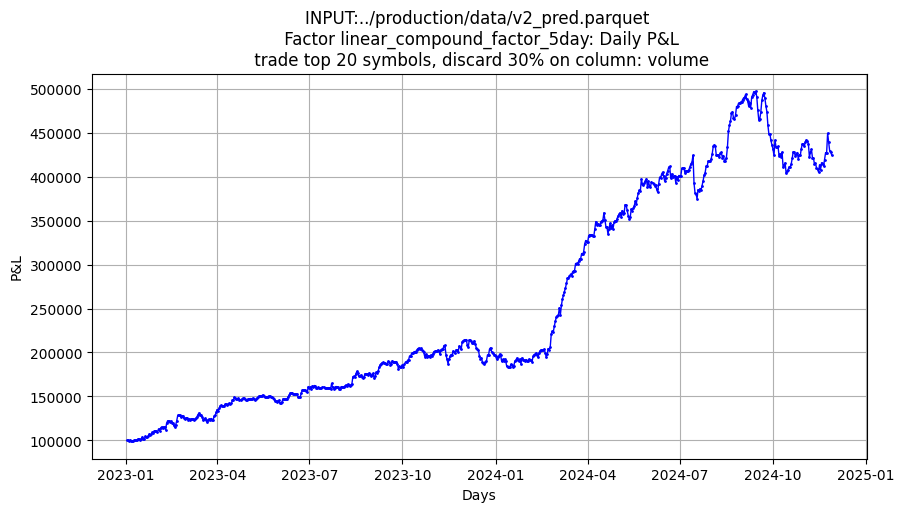

In [36]:
time_array = result_hour['open_time'].unique().sort().to_numpy()
pnl = best_pnl
plt.figure(figsize=(10, 5))  # You can adjust the figure size as needed
plt.plot(time_array[0:len (pnl)], pnl, marker='o', linestyle='-', color='b', linewidth=1, markersize=1)  # 'o' is the marker, line-style is solid by default
# plt.plot( pnl, marker='o', linestyle='-', color='b', linewidth=1, markersize=1)  # 'o' is the marker, line-style is solid by default
plt.title(f'INPUT:{LINEAR_INPUT_FILE} \n Factor {best_factor_name}: Daily P&L\n trade top {TRADE_RANK_NUM} symbols, discard {VOL_FILTER_RATIO}% on column: {VOL_COL_FILTER_NAME}')
plt.xlabel('Days')
plt.ylabel('P&L')
plt.grid(True)  # Turn on the grid for better readability of the plot
plt.show()